Take the data from open flights and make a dataframe of just UK 

In [6]:
import pandas as pd
import io
import requests

url="https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
schema = ['Airport ID','Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','Tz database time zone','Type','Source']

s=requests.get(url).content
airports=pd.read_csv(io.StringIO(s.decode('utf-8')),names=schema)

airports[airports['Country']=='United Kingdom'].head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
461,465,Belfast International Airport,Belfast,United Kingdom,BFS,EGAA,54.657501,-6.21583,268,0,E,Europe/London,airport,OurAirports
462,466,St Angelo Airport,Enniskillen,United Kingdom,ENK,EGAB,54.398899,-7.65167,155,0,E,Europe/London,airport,OurAirports
463,467,George Best Belfast City Airport,Belfast,United Kingdom,BHD,EGAC,54.618099,-5.87250,15,0,E,Europe/London,airport,OurAirports
464,468,City of Derry Airport,Londonderry,United Kingdom,LDY,EGAE,55.042801,-7.16111,22,0,E,Europe/London,airport,OurAirports
465,469,Birmingham International Airport,Birmingham,United Kingdom,BHX,EGBB,52.453899,-1.74803,327,0,E,Europe/London,airport,OurAirports


Now take Southampton as an example

In [7]:
Southampton = airports[airports['ICAO']=='EGHI']
Southampton.head()


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
490,495,Southampton Airport,Southampton,United Kingdom,SOU,EGHI,50.950298,-1.3568,44,0,E,Europe/London,airport,OurAirports


In [8]:
# Using:
#    Latitude: 1 deg = 110.574 km
#    Longitude: 1 deg = 111.320*cos(latitude) km
# To covert a radius to (lat, long)
import numpy as np


lat_lim = 1/110.574
long_lim = 1/(111.32*np.cos(np.deg2rad(51)))



The UAS FM grides are 1 min * 1 min

In [40]:
import matplotlib.pyplot as plt

print("Centre of SOU:",Southampton['Latitude'].values,Southampton['Longitude'].values)

x0, y0 = Southampton['Longitude'].values, Southampton['Latitude'].values

x_start, x_end = x0-2.1e-1, x0+2.1e-1
y_start, y_end = y0-2.1e-1, y0+2.1e-1


#x_start, x_end = np.round(x0-2.0e-1,3), np.round(x0+2.0e-1,3)
#y_start, y_end = np.round(y0-2.0e-1,3), np.round(y0+2.0e-1,3)

x = np.arange(x_start,x_end,1/60) # Create a range of points seperated by 1 min.
y = np.arange(y_start,y_end,1/60) # Create a range of points seperated by 1 min.

x , y = np.meshgrid(x,y)

Centre of SOU: [50.95029831] [-1.35679996]


In [42]:
import pandas as pd

df = pd.DataFrame({'Longitude': x.flatten(),
                   'Latitude': y.flatten(),
                   'UAS restriction' : False})

In [43]:
def haversine(row):
    import math
    lon1 = -1.35679996
    lat1 = 50.95029831
    lon2 = row['Longitude']
    lat2 = row['Latitude']
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6367 * c
    return km

df['Distance from aerodrome centre (km)'] = df.apply(lambda row: haversine(row), axis=1)
df['UAS restriction']= (df['Distance from aerodrome centre (km)'] <= 3)
df['UAS warning']=  df['Distance from aerodrome centre (km)'].between(3, 10, inclusive=False)

df.head()

,Latitude,Longitude,UAS restriction,Distance from aerodrome centre (km),UAS warning
0,50.740298,-1.566800,False,27.598871,False
1,50.740298,-1.550133,False,26.992636,False
2,50.740298,-1.533467,False,26.424274,False
3,50.740298,-1.516800,False,25.896280,False
4,50.740298,-1.500133,False,25.411168,False


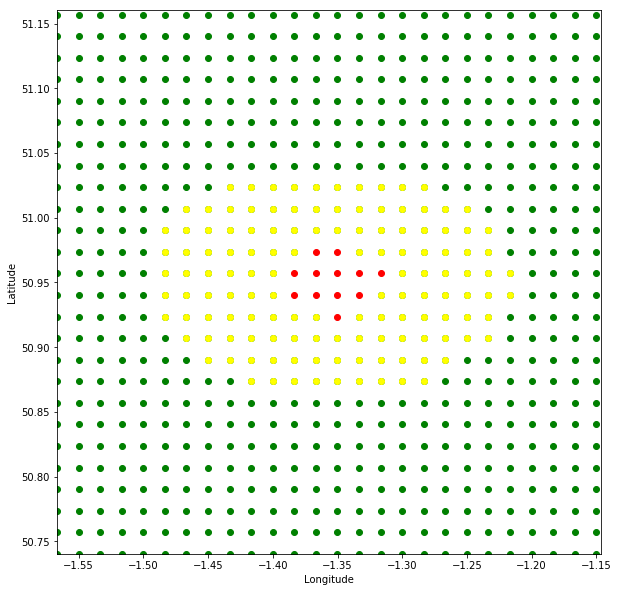

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlabel='X', ylabel='Y', aspect=1.0)
ax.scatter(df[df['UAS restriction']==True]['Longitude'],df[df['UAS restriction']==True]['Latitude'],color='red')
ax.scatter(df[df['UAS restriction']==False]['Longitude'],df[df['UAS restriction']==False]['Latitude'],color='green')
ax.scatter(df[df['UAS warning']==True]['Longitude'],df[df['UAS warning']==True]['Latitude'],color='yellow')

ax.set_xlim([x_start, x_end ])
ax.set_ylim([y_start, y_end ])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.plot(Southampton['Latitude'].values,Southampton['Longitude'].values,color='black',marker='*',markersize=20)
plt.show()

In [46]:
import pandas as pd
import folium

folium_map = folium.Map(location=[ 50.95029831,-1.35679996],
                        zoom_start=13)

#folium.CircleMarker(location=[50.95029831,-1.35679996],fill=True,radius=100).add_to(folium_map)



restriction = df[df['UAS restriction']==True]
restriction.apply(lambda x: folium.CircleMarker(location=[x['Latitude'],x['Longitude'] ],fill=True,radius=7,color='red').add_to(folium_map),axis=1)

safe = df[df['UAS restriction']==False]
safe.apply(lambda x: folium.CircleMarker(location=[x['Latitude'],x['Longitude'] ],fill=True,radius=7,color='green').add_to(folium_map),axis=1)




folium_map